In [10]:
from sasha_tools import *
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from itertools import product

import pandas as pd
import numpy as np

In [12]:
df = pd.read_csv('sample.csv', sep = ';')

In [13]:
df['date'] = pd.to_datetime(df['APPDATE'].apply(lambda x : str(x)[:10]), format = '%d.%m.%Y')


train_indx = (df['date'] <= '2022-03-31')
'Fraction of train is: ', round(train_indx.mean(), 3)

('Fraction of train is: ', 0.803)

In [17]:
df_copy = df[train_indx].copy(deep = True)

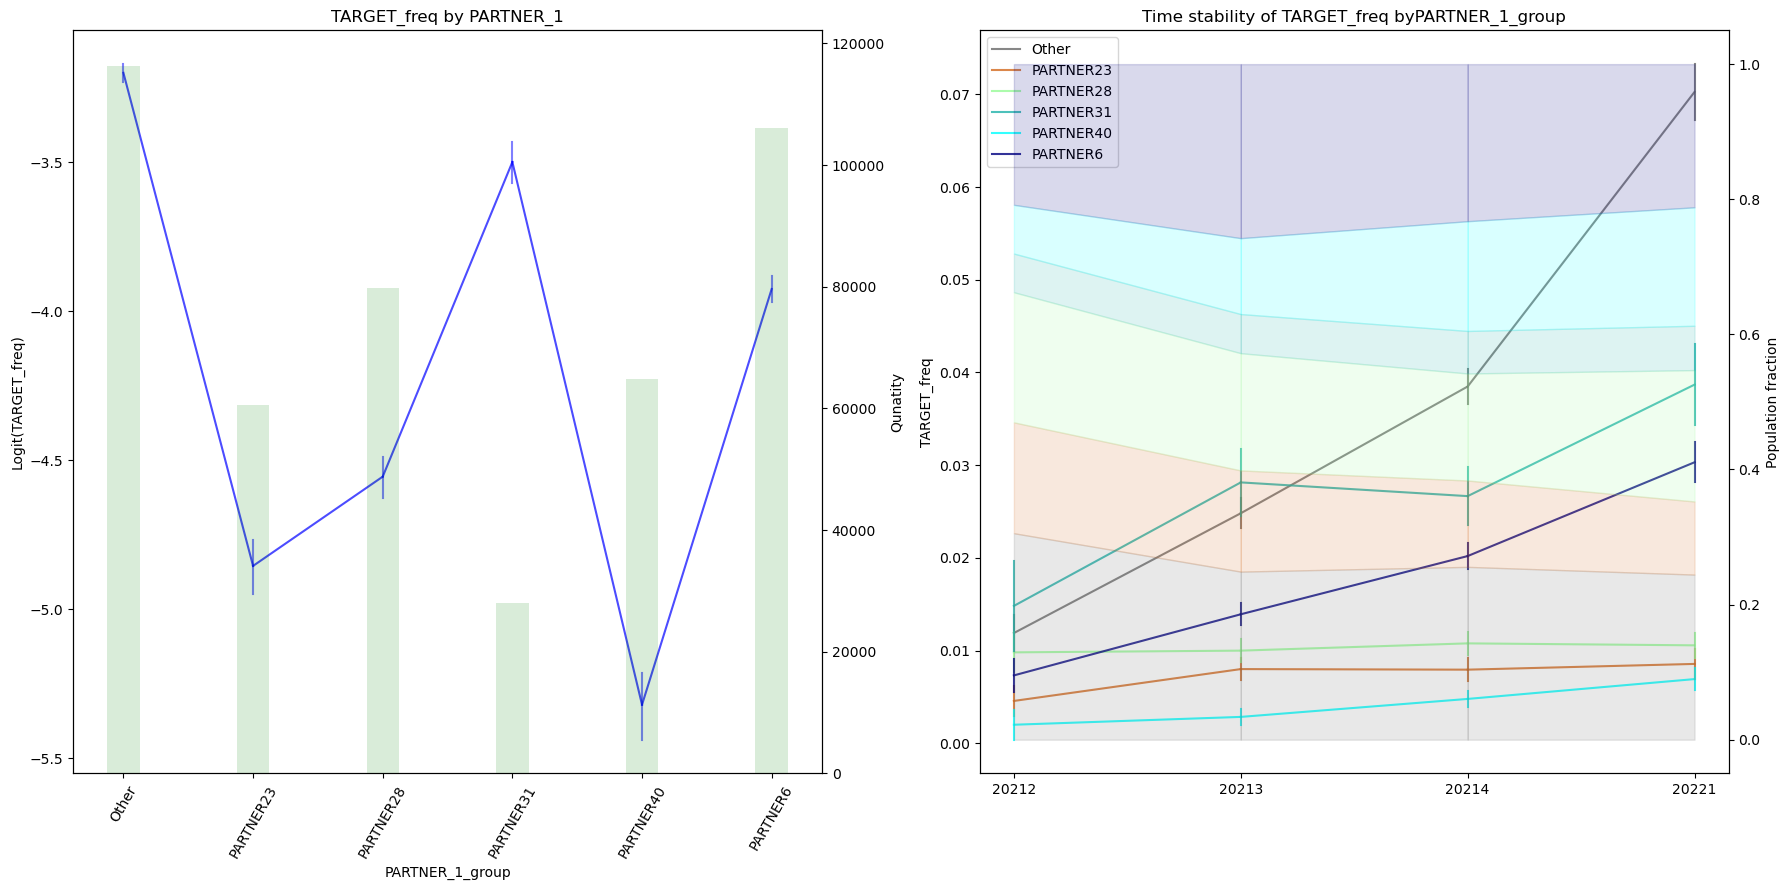

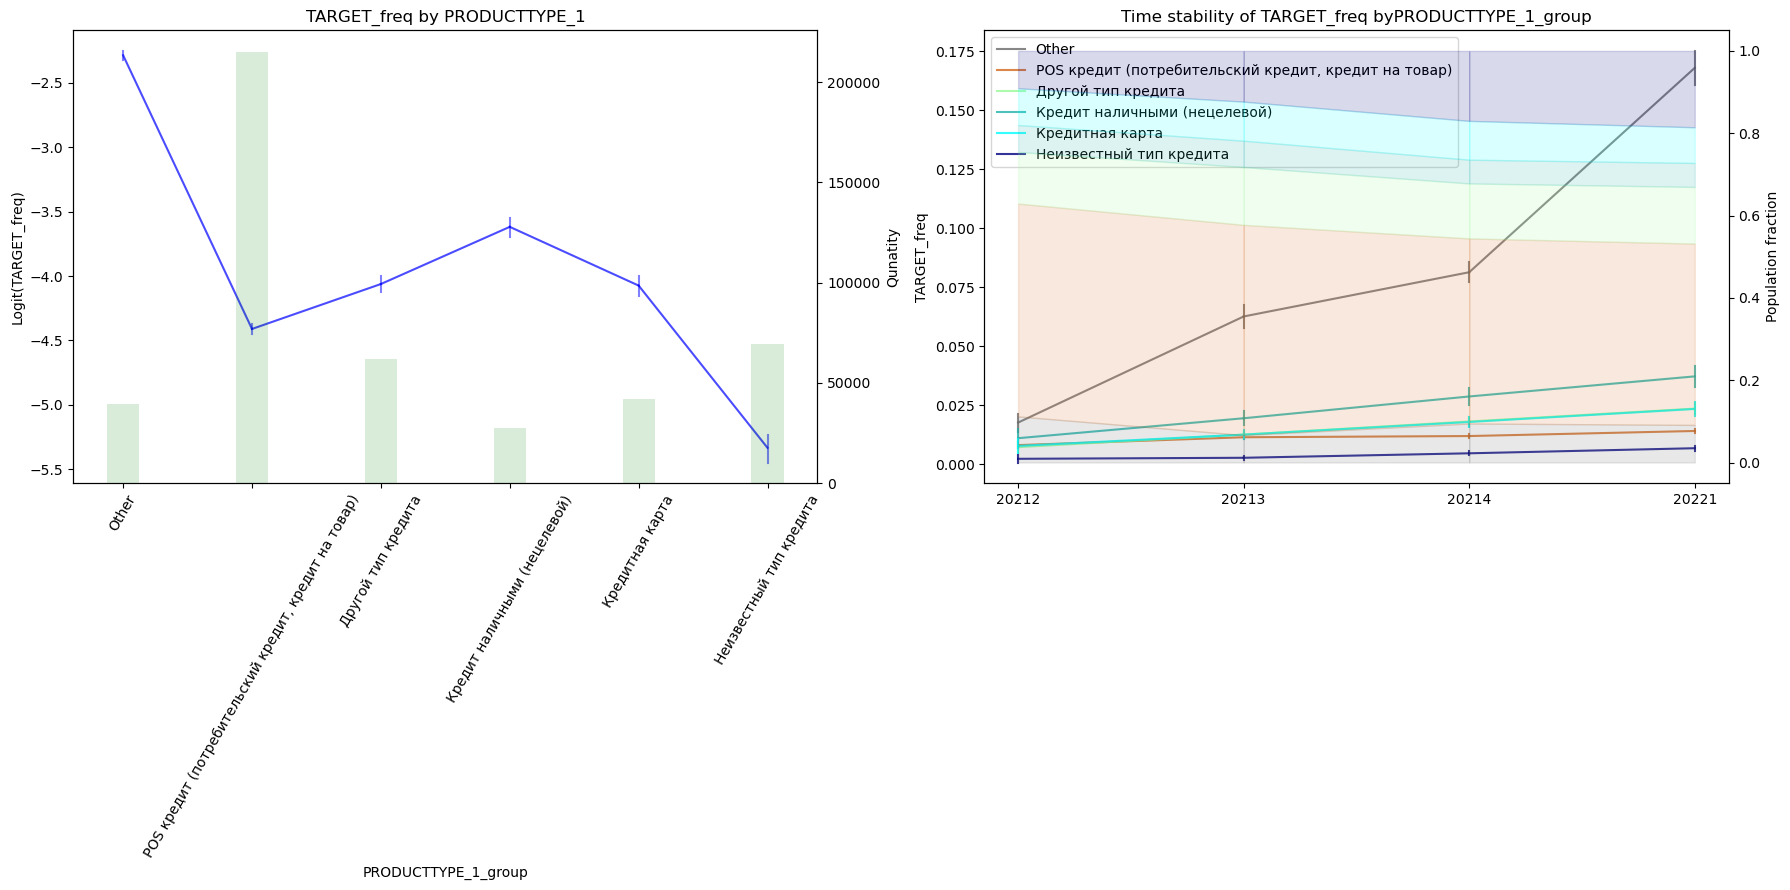

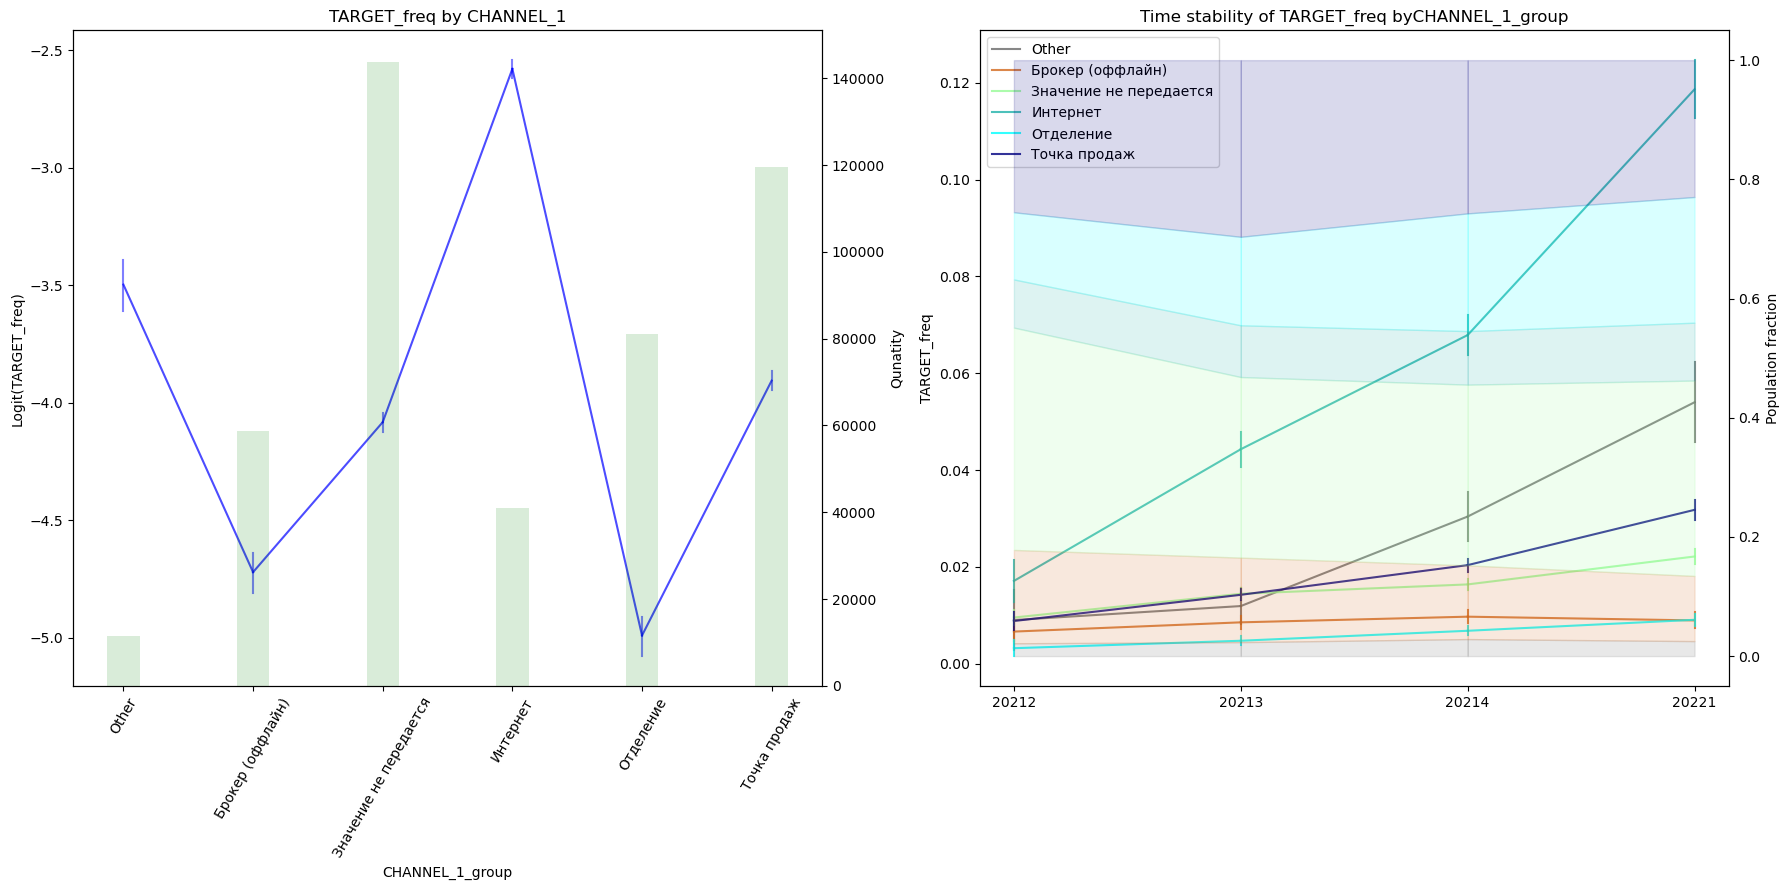

In [48]:
#All the PARTNER, PRODUCTTYPE, CHANNEL have one dimensional influence on target

popular_channels = df['CHANNEL'].fillna('NotGiven').value_counts().index[:5]
df_copy['CHANNEL_1'] = df_copy['CHANNEL']
df_copy.loc[~df_copy['CHANNEL'].isin(popular_channels),
            'CHANNEL_1'
            ] = 'Other'

popular_credits = df['PRODUCTTYPE'].fillna('NotGiven').value_counts().index[:5]
df_copy['PRODUCTTYPE_1'] = df_copy['PRODUCTTYPE']
df_copy.loc[~df_copy['PRODUCTTYPE'].isin(popular_credits),
            'PRODUCTTYPE_1'
            ] = 'Other'

popular_partner = df['PARTNER'].fillna('NotGiven').value_counts().index[:5]
df_copy['PARTNER_1'] = df_copy['PARTNER']
df_copy.loc[~df_copy['PARTNER'].isin(popular_partner),
            'PARTNER_1'
            ] = 'Other'


qwe = one_dim_analysis(df = df_copy,
                prop = 'PARTNER_1',
                weight = 'edinici',
                target = 'TARGET',
                time = 'quarter',
                split_group_flag = False,
                n_groups = 6,
                time_flag = True,
                bootstrap = False
                )

qwe = one_dim_analysis(df = df_copy,
                prop = 'PRODUCTTYPE_1',
                weight = 'edinici',
                target = 'TARGET',
                time = 'quarter',
                split_group_flag = False,
                n_groups = 6,
                time_flag = True,
                bootstrap = False
                )

qwe = one_dim_analysis(df = df_copy,
                prop = 'CHANNEL_1',
                weight = 'edinici',
                target = 'TARGET',
                time = 'quarter',
                split_group_flag = False,
                n_groups = 6,
                time_flag = True,
                bootstrap = False
                )

In [22]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from itertools import product

learning_rate = np.logspace(-4, 0, 5, base = 2)
depth = [2, 3, 5, 7]
params_results = {}

#Lets mix them in a catboostmapping
cat_features = ['PARTNER', 'PRODUCTTYPE', 'CHANNEL']

X_train, X_val, y_train, y_val = train_test_split(df_copy[cat_features], df_copy['TARGET'], test_size = 0.5, random_state = 42)


for i, (l_r, d) in enumerate(product(learning_rate, depth)):
    if not i%5:
        print(i, (l_r, d)) 
    clf = CatBoostClassifier(
    iterations = 120, 
    loss_function='Logloss',
    eval_metric = 'AUC',
    random_seed = 42,
    learning_rate = l_r,
    depth = d,
    )
    clf.fit(X_train, y_train, 
            cat_features = cat_features, 
            eval_set = (X_val, y_val), 
            verbose = False
            )
    params_results[(l_r, d)] = clf.evals_result_['validation']['AUC']
'''
print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())
'''

0 (0.0625, 2)
5 (0.125, 3)
10 (0.25, 5)
15 (0.5, 7)


"\nprint('CatBoost model is fitted: ' + str(clf.is_fitted()))\nprint('CatBoost model parameters:')\nprint(clf.get_params())\n"

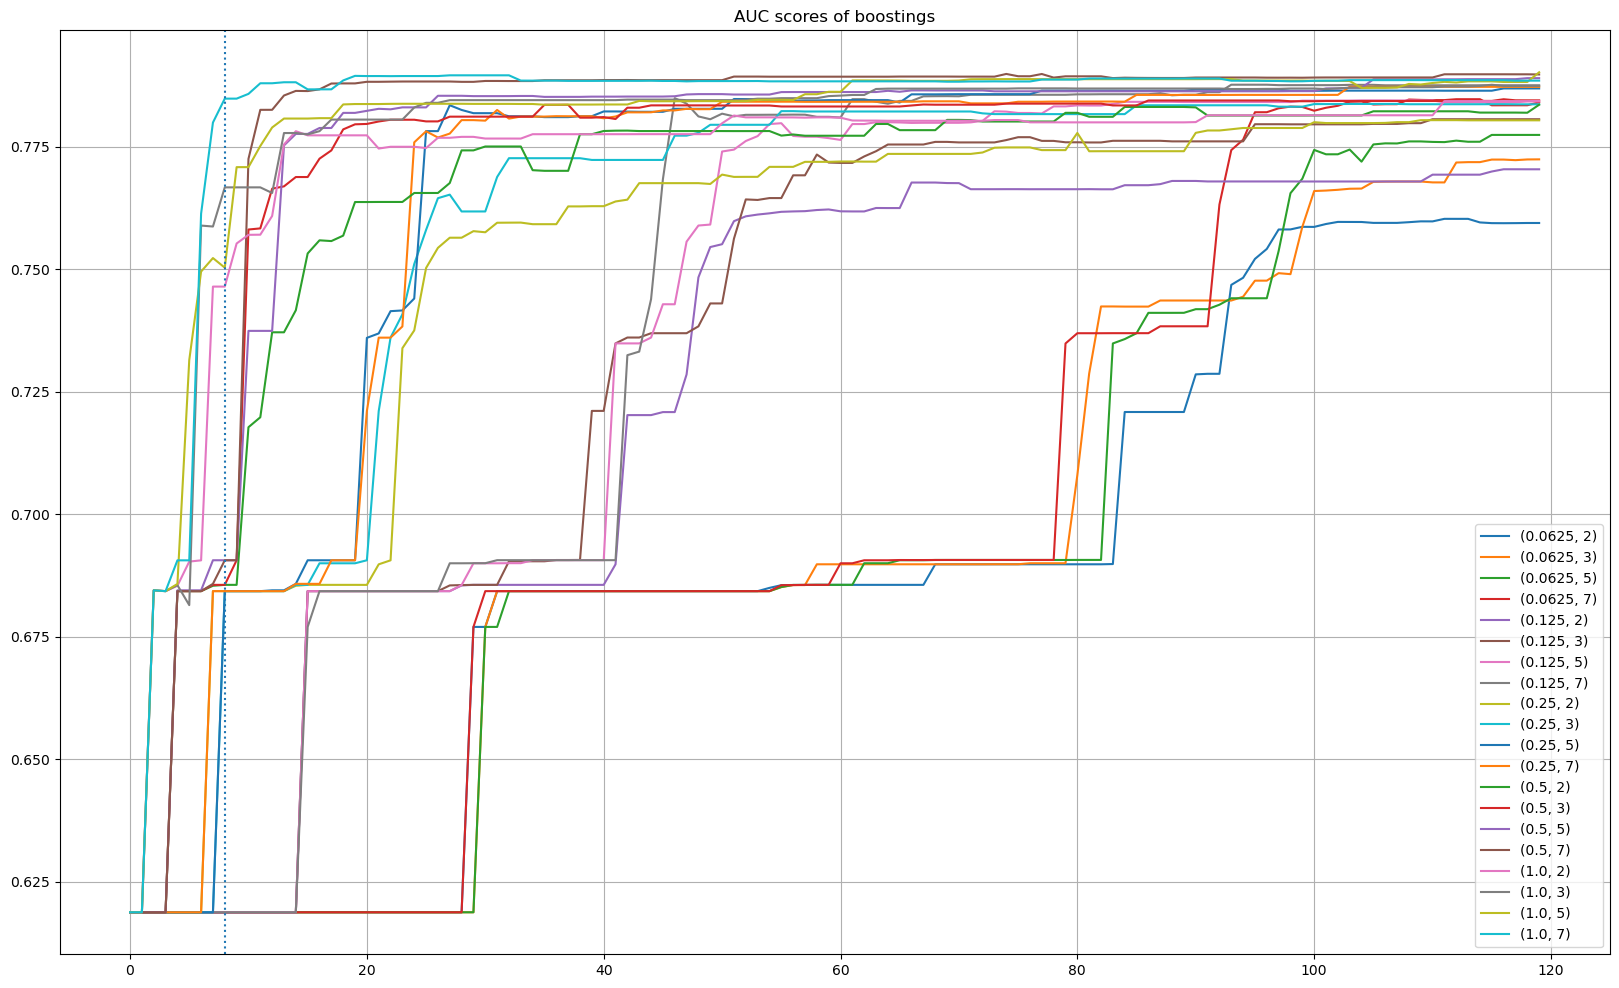

In [32]:
plt.figure(figsize = (20, 12))
for k, v in params_results.items():
    plt.plot(range(len(v)), v, label = k)
plt.grid()
plt.axvline(8, ls = ':')
plt.title('AUC scores of boostings')
plt.legend()

In [ ]:
#Lets fix params: depth = 7, learning_rate = 1 and acquire a cb_score
clf_res = CatBoostClassifier(
    iterations = 120, 
    loss_function='Logloss',
    eval_metric = 'AUC',
    random_seed = 42,
    learning_rate = 1,
    depth = 7,
    )
clf_res.fit(X_train, y_train, 
        cat_features = cat_features, 
        eval_set = (X_val, y_val), 
        verbose = False
        )

In [35]:
df_copy['cb_score'] = clf_res.predict_proba(df_copy[cat_features],
                                             ntree_end = 9)[:, 1]
df_copy['cb_score_map'] = np.log(df_copy['cb_score'] / (1 - df_copy['cb_score']))

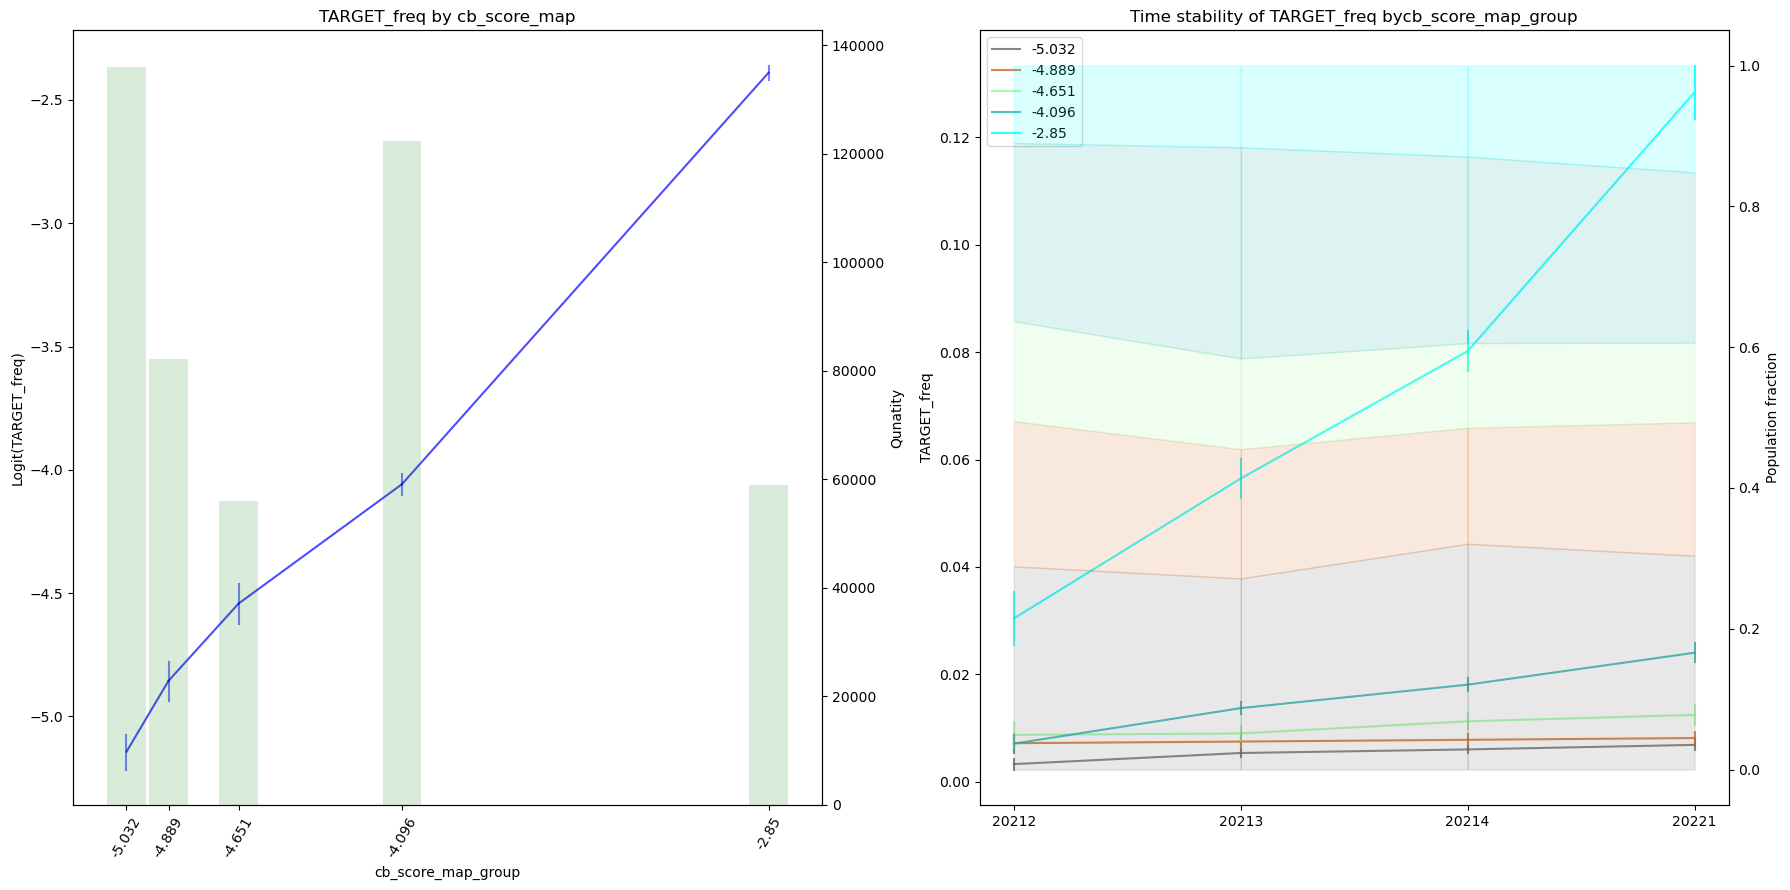

In [39]:
#Linearization of a feature
df_copy['edinici'] = 1
df_copy['quarter'] = df_copy['date'].dt.year * 10 + df_copy['date'].dt.quarter
qwe = one_dim_analysis(df = df_copy,
                prop = 'cb_score_map',
                weight = 'edinici',
                target = 'TARGET',
                time = 'quarter',
                split_group_flag = True,
                n_groups = 5,
                time_flag = True,
                bootstrap = False
                )

In [44]:
#Saving catboost scores for final model

df['cb_score'] = clf_res.predict_proba(df[cat_features],
                                             ntree_end = 9)[:, 1]
df['cb_score_map'] = np.log(df['cb_score'] / (1 - df['cb_score']))

df[['APPID', 'cb_score_map']].to_csv('cb_score.csv', index = False)